In [2]:
import numpy as np
import xarray as xr
import pandas as pd
from plotting_fxns import *
import matplotlib as mpl
import matplotlib.pyplot as plt
import os
import cmasher as cmr
%load_ext autoreload
%autoreload 2
sites = ['Z','T','EC','KPS']

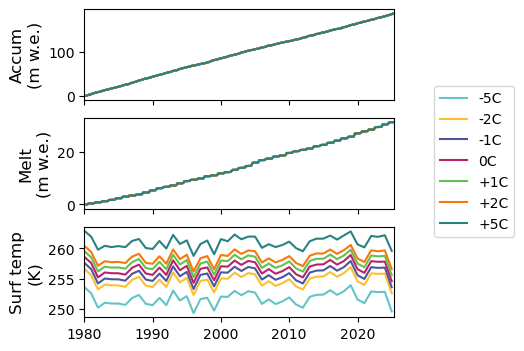

In [32]:
# # compare forcings
site = 'KPS'
diff = '5C'
fig, axes = plt.subplots(3, figsize=(4, 4), sharex=True)
lax = fig.add_axes((1, 0.25, 0.2,0.5))

forcing_fp = '/trace/group/rounce/cvwilson/Firn/Forcings/'
# for site in sites:
for d, diff in enumerate(['-5C','-2C','-1C','0C','+1C','+2C','+5C']):
# for d, diff in enumerate([0.5,0.667,0.9,1,1.1,1.5,2]):
    glacier = 'wolverine' if site == 'EC' else 'kahiltna' if site == 'KPS' else 'gulkana'
    fn = forcing_fp + f'{glacier}{site}/{glacier}{site}_TS{diff[:-1]}_1d_forcings.csv'
    df = pd.read_csv(fn, index_col=0)
    df.index = pd.to_datetime(df.index)
    axes[0].plot(df.index, df['BDOT'].cumsum() / 1000, color=colors[d]) #diff[:-1])
    axes[1].plot(df.index, df['SMELT'].cumsum() / 1000, color=colors[d])
    axes[2].plot(df['TS'].resample('YS').mean().index, df['TS'].resample('YS').mean(), color=colors[d])
    lax.plot(np.nan, np.nan, label = str(diff), color=colors[d])
lax.axis('off')
lax.legend(loc='center')
axes[0].set_ylabel('Accum\n(m w.e.)',fontsize=12)
axes[1].set_ylabel('Melt\n(m w.e.)',fontsize=12)
axes[2].set_ylabel('Surf temp\n(K)',fontsize=12)
axes[2].set_xlim(df.index[0], df.index[-1])
axes[2].set_xticks(pd.date_range('1980-01-01','2025-01-01',freq='10YS'))
axes[2].xaxis.set_major_formatter(mpl.dates.DateFormatter('%Y'))

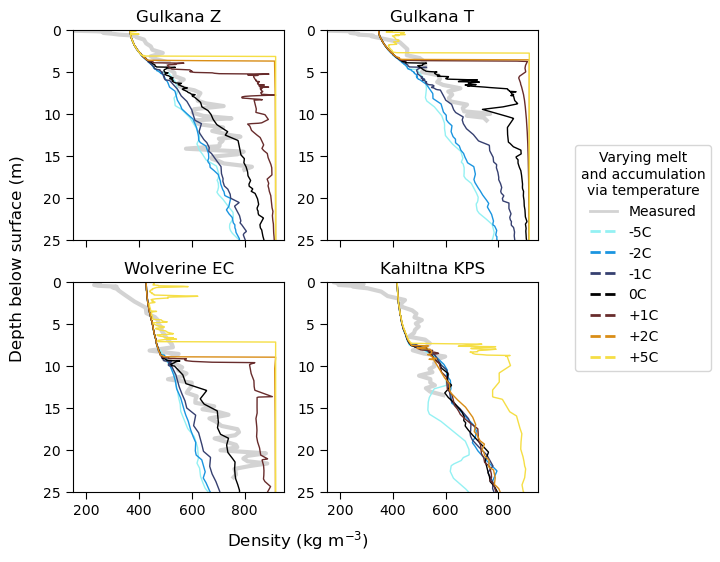

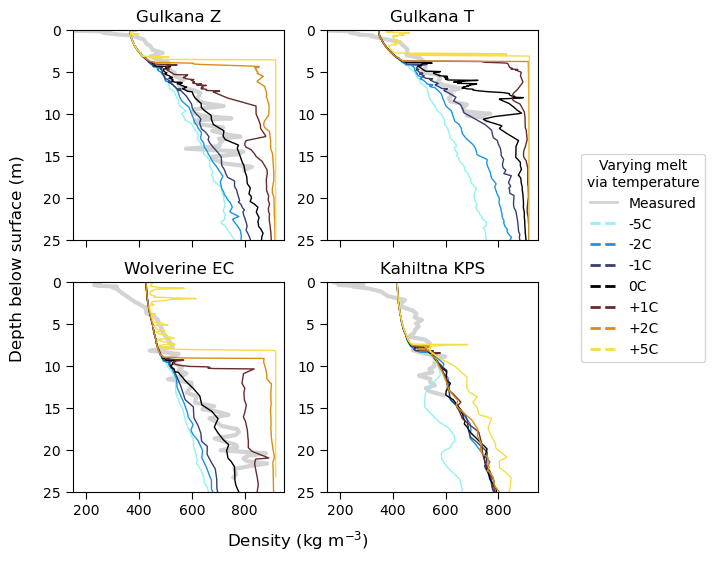

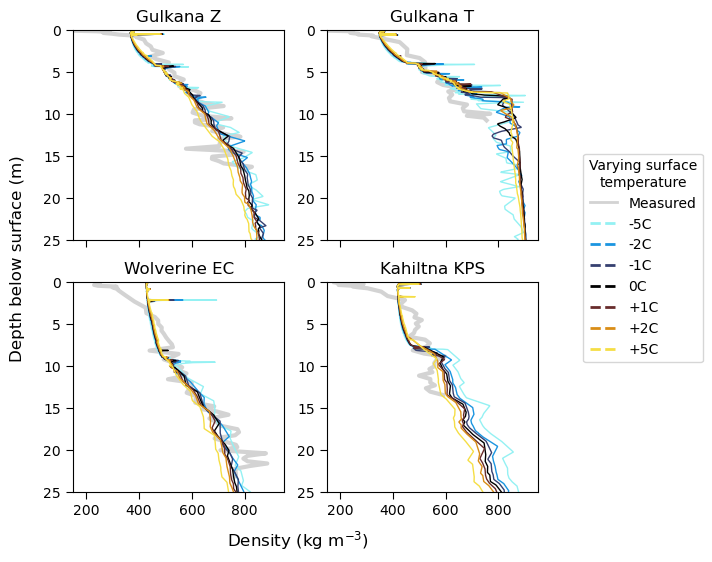

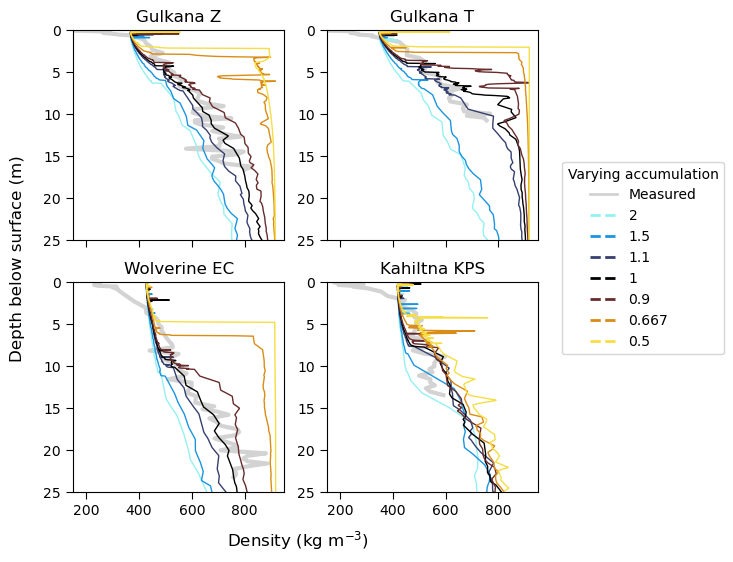

In [10]:
# MODELED DENSITY COMPARISON
change = 'temp'
updated_accum = False
out_fp = '/trace/group/rounce/cvwilson/Firn/Output/'

sites = ['Z','T','EC','KPS'] # 
for change_tuple in [('temp', True), ('temp', False), ('stemp', True), ('precip', True)]:
    change, updated_accum = change_tuple
    fig, axes = plt.subplots(2,2, figsize=(6,6), sharex=True) #,gridspec_kw={'hspace':0.4})
    axes = axes.flatten()
    for s, site in enumerate(sites):
        ax = axes[s]
        all_measured = []
        all_modeled = []
        all_labels = []
        failed = []

        glacier = 'wolverine' if site == 'EC' else 'kahiltna' if site == 'KPS' else 'gulkana'
        date = dates_wolverine[-1] if site == 'EC' else dates_kahiltna[-1] if site == 'KPS' else '2025_04_20'
        density_meas, layer_tops, layer_bottoms = get_density_measured(site, date)

        if 'temp' in change:
            change_factors = [-5, -2, -1, 0, 1, 2, 5]
        elif change == 'precip':
            change_factors = [2,1.5,1.1,1,0.9,0.667,0.5] # [0.5, 0.667, 0.9, 1, 1.1, 1.5, 2]
        for factor in change_factors:
            # Get labels
            if 'temp' in change:
                factor_str = '+'+str(factor) if factor > 0 else str(factor)
                label = factor_str + 'C'
            elif change == 'precip':
                factor_str = str(factor)
                label = factor_str
            all_labels.append(label)

            if change == 'precip':
                cfm_fn = f'{glacier}{site}/{glacier}{site}_{factor_str}_0/CFMresults.hdf5'
            elif change == 'temp' and not updated_accum:
                cfm_fn = f'{glacier}{site}/{glacier}{site}_{factor_str}_sameacc_0/CFMresults.hdf5'
            elif change == 'temp':
                cfm_fn = f'{glacier}{site}/{glacier}{site}_{factor_str}_0/CFMresults.hdf5'
            elif change == 'stemp':
                cfm_fn = f'{glacier}{site}/{glacier}{site}_TS{factor_str}_0/CFMresults.hdf5'
            if not os.path.exists(out_fp + cfm_fn):
                failed.append((factor_str, site))
                print(factor_str, 'failed for site', site)
                modeled = ([np.nan], [np.nan])
            else:
                # load data
                modeled = get_var_modeled(out_fp + cfm_fn, date, 'density')

            all_measured.append((density_meas, layer_bottoms, layer_tops))
            all_modeled.append(modeled)

        # plot
        axes[s] = simple_comparison(site, all_measured, all_modeled, all_labels, 
                                    print_error=False,color_scheme='continuous', plot_ax = ax)
        axes[s].set_xlabel('')
        axes[s].set_ylabel('')
        axes[s].set_title(f'{glacier.capitalize()} {site}')
        axes[s].set_ylim(25, 0)

    lax = fig.add_axes((1, 0.25, 0.15, 0.5))
    lax.plot(np.nan, np.nan, color='lightgray',label='Measured', linewidth=2)
    for i in range(len(change_factors)):
        cmap = cmr.iceburn
        norm = mpl.colors.Normalize(vmin=0, vmax=len(change_factors)-1)
        if i == 2:
            color = cmap(norm(1.4))
        if i == 4:
            color = cmap(norm(4.6))
        if i == 1:
            color = cmap(norm(0.7))
        if i == 5:
            color = cmap(norm(5.3))
        else:
            color = cmap(norm(i))
        lax.plot(np.nan, np.nan, color=color, label=all_labels[i],linestyle='--', linewidth=2)
    lax.axis('off')
    lax_titles = {'precip': 'Varying accumulation',
                  'temp': 'Varying melt\nvia temperature',
                  'stemp': 'Varying surface\ntemperature'}
    lax_title = lax_titles[change]
    if updated_accum and change == 'temp':
        lax_title = 'Varying melt\nand accumulation\nvia temperature'
    leg = lax.legend(fontsize=10, loc='center', title=lax_title)
    leg.get_title().set_ha('center') 
    fig.supxlabel('Density (kg m$^{-3}$)')
    fig.supylabel('Depth below surface (m)')
    fp_fig = f'../Data/{change}_change_comparison_Crocus.png'
    if not updated_accum and change == 'temp':
        fp_fig = f'../Data/{change}_sameacc_change_comparison_Crocus.png'
    plt.savefig(fp_fig, dpi=300, bbox_inches='tight')
    plt.show()

In [19]:
# GENERATE FORCING FILES FOR SENSITIVITY TEST
def rain_fraction(temp):
        return np.clip((temp - 0.2) / (2.2 - 0.2), 0, 1)
for site in sites:
    glacier = 'wolverine' if site == 'EC' else 'kahiltna' if site == 'KPS' else 'gulkana'

    # data_fp = '../Data/'
    data_fp = '/trace/group/rounce/cvwilson/Output/'
    # forcing_fp = '../../Firn/Forcings'
    forcing_fp = '/trace/group/rounce/cvwilson/Firn/Forcings/'
    ds = xr.open_dataset(data_fp + f'{glacier.capitalize()}_2025_09_16_long{site}_climate.nc')
    airtemp_daily = ds.temp.resample(time='d').mean()
    df = pd.read_csv(forcing_fp + f'{glacier}{site}/{glacier}{site}_1d_forcings.csv',index_col=0)
    df.index = pd.to_datetime(df.index)

    # make varying temp/melt files
    df['AIRTEMP'] = airtemp_daily.sel(time=df.index).values
    df['PDD'] = df['AIRTEMP'].copy(deep=True)
    df.loc[df['PDD'] <= 0, 'PDD'] = 0
    annual_ddf = df.groupby(df.index.year).apply(
                lambda g: g['SMELT'].sum() / g['PDD'].sum() if g['PDD'].sum() > 0 else np.nan
                )
    annual_ddf = annual_ddf.fillna(np.nanmean(annual_ddf))

    for update_accum in [True, False]:
        for temp_change in [-5, -2, -1, 0, 1, 2, 5]:
            temp_change_str = '+'+str(temp_change) if temp_change > 0 else temp_change
            df_adj = df.copy(deep=True)
            # ADJUST TEMPERATURE
            df_adj['AIRTEMP'] += temp_change
            # RECALCULATE MELT FROM PDDS
            df_adj['PDD'] = df_adj['AIRTEMP'].copy()
            df_adj.loc[df_adj['PDD'] < 0, 'PDD'] = 0
            df_adj['YEAR'] = df_adj.index.year
            df_adj['DDF'] = df_adj['YEAR'].map(annual_ddf)
            df_adj['SMELT'] = df_adj['PDD'] * df_adj['DDF']

            if update_accum:
                # TRACK TOTAL PRECIP
                df_adj['PRECIP'] = df_adj['RAIN'] + df_adj['BDOT']
                df_adj['RAIN_FRAC'] = rain_fraction(df_adj['AIRTEMP'])
                # DAYS BELOW 0: CONVERT RAIN TO ACCUM, THEN REMOVE RAIN
                df_adj['RAIN'] = df_adj['PRECIP'] * df_adj['RAIN_FRAC']
                df_adj['BDOT'] = df_adj['PRECIP'] * (1 - df_adj['RAIN_FRAC'])
                df_adj = df_adj.drop(columns=['AIRTEMP','PDD','PRECIP','RAIN_FRAC'])
                fn = forcing_fp + f'{glacier}{site}/{glacier}{site}_{temp_change_str}C_1d_forcings.csv'
            else:
                df_adj = df_adj.drop(columns=['AIRTEMP','PDD'])
                fn = forcing_fp + f'{glacier}{site}/{glacier}{site}_{temp_change_str}C_sameacc_1d_forcings.csv'
            # PRINT CHANGES
            sum_melt_change = np.sum(df_adj['SMELT'] - df['SMELT']) / 1000
            sum_rain_change = np.sum(df_adj['RAIN'] - df['RAIN']) / 1000
            sum_accum_change = np.sum(df_adj['BDOT'] - df['BDOT']) / 1000
            # print(temp_change, 'change in melt', sum_melt_change, 'change in rain', sum_rain_change, 'change in accum', sum_accum_change)
            # STORE
            df_adj.to_csv(fn)
        # print(df_adj.head())
        print(f'produced temp files for site {site}')

    # make varying precip files
    for precip_change in [0.5, 0.667, 0.9, 1, 1.1, 1.5, 2]:
        df_adj = df.copy(deep=True)
        # ADJUST ACCUMULATION
        df_adj['BDOT'] *= precip_change
        # PRINT CHANGES
        sum_melt_change = np.sum(df_adj['SMELT'] - df['SMELT']) / 1000
        sum_rain_change = np.sum(df_adj['RAIN'] - df['RAIN']) / 1000
        sum_accum_change = np.sum(df_adj['BDOT'] - df['BDOT']) / 1000
        # print(precip_change, 'change in melt', sum_melt_change, 'change in rain', sum_rain_change, 'change in accum', sum_accum_change)
        # STORE
        df_adj = df_adj.drop(columns=['AIRTEMP'])
        fn = forcing_fp + f'{glacier}{site}/{glacier}{site}_{precip_change}_1d_forcings.csv'
        df_adj.to_csv(fn)
    # print(df_adj.head())
    print(f'produced precip files for site {site}')

    for surftemp_change in [-5, -2, -1, 0, 1, 2, 5]:
        temp_change_str = '+'+str(surftemp_change) if surftemp_change > 0 else surftemp_change
        df_adj = df.copy(deep=True)
        df_adj['TS'] += surftemp_change
        df_adj.loc[df_adj['TS'] > 273.15, 'TS'] = 273.15
        mean_stemp_change = np.mean(df_adj['TS'] - df['TS']) 
        # print(mean_stemp_change, 'change in surf temp')
        fn = forcing_fp + f'{glacier}{site}/{glacier}{site}_TS{temp_change_str}_1d_forcings.csv'
        df_adj.to_csv(fn)
    # print(df_adj.head())
    print(f'produced surftemp files for site {site}')

produced temp files for site Z
produced temp files for site Z
produced precip files for site Z
produced surftemp files for site Z
produced temp files for site T
produced temp files for site T
produced precip files for site T
produced surftemp files for site T
produced temp files for site EC
produced temp files for site EC
produced precip files for site EC
produced surftemp files for site EC
produced temp files for site KPS
produced temp files for site KPS
produced precip files for site KPS
produced surftemp files for site KPS


In [ ]:
# END